Lie, Samuel Miracle Kristanto - 0706012210011
Nathan Darrell - 0706012210034

In [43]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("\n\nNumber of GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

2.16.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16618574810310806031
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 17735429335653234086
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


Number of GPUs Available:  1


2025-05-26 15:56:40.987026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 15:56:40.987050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Read Dataset & Preprocessing

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

In [45]:
data_dir = '/Users/attraqtia/Documents/ComVis/Main'
# Size dari datasetnya 512
width = height = 224
batch_size = 16

In [ ]:
raw_train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = raw_train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1./255)

# This need some explanation!
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)

validation_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
).map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

Found 120959 files belonging to 2 classes.
Using 84672 files for training.
['fake', 'real']
Found 120959 files belonging to 2 classes.
Using 36287 files for validation.


## Model Building --> MobileNetV3

In [47]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

In [48]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.metrics import AUC

def inverted_residual_block(x, input_channels, output_channels, expansion_factor, strides):
    x_input = x  # Save for residual connection
    expanded_channels = int(input_channels * expansion_factor)

    if expansion_factor != 1:
        x = Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if strides == 1 and input_channels == output_channels:
        x = Add()([x_input, x])

    return x


def MobileNetV3_Model(input_shape=(224, 224, 3), num_classes=1):
    # Pake augmentationnya
    input = Input(shape=input_shape)
    x = data_augmentation(input)
    x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = inverted_residual_block(x, 16, 16, expansion_factor=1, strides=1)
    x = inverted_residual_block(x, 16, 24, expansion_factor=4, strides=2)
    x = inverted_residual_block(x, 24, 24, expansion_factor=3, strides=1)
    x = inverted_residual_block(x, 24, 40, expansion_factor=3, strides=2)
    x = inverted_residual_block(x, 40, 40, expansion_factor=3, strides=1)
    x = inverted_residual_block(x, 40, 80, expansion_factor=6, strides=2)
    x = inverted_residual_block(x, 80, 80, expansion_factor=2.5, strides=1)

    x = Conv2D(1280, kernel_size=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=input, outputs=output)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()]
    )

    return model

In [49]:
model = MobileNetV3_Model(input_shape=(224, 224, 3))
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 112, 112,  │        432 │ sequential_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_45 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_21 │ (None, 112, 112,  │        144 │ re_lu_45[0][0]    │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_46 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 112, 112,  │        256 │ re_lu_46[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 112, 112,  │          0 │ re_lu_45[0][0],   │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 112, 112,  │      1,024 │ add_12[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_22 │ (None, 56, 56,    │        576 │ re_lu_47[0][0]    │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_48 (ReLU)     │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 205,057 (801.00 KB)

 Trainable params: 198,753 (776.38 KB)

 Non-trainable params: 6,304 (24.62 KB)

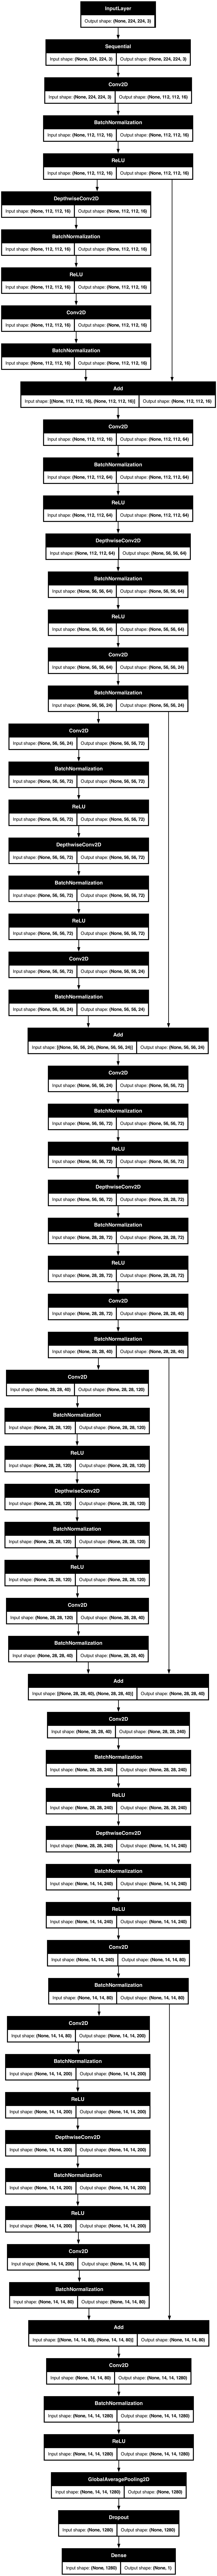

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [53]:
from datetime import datetime

start_time = datetime.now()

history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = 10,
    validation_data = validation_ds,
    verbose = 1,
    callbacks=[lr_callback, early_stop]
)

end_time = datetime.now()

model.save('/Users/attraqtia/Documents/ComVis/reyal_fakeh_model.h5')

Epoch 1/10
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 525s 192ms/step - accuracy: 0.6566 - auc: 0.6959 - loss: 0.6279 - precision_3: 0.6819 - recall_3: 0.7632 - val_accuracy: 0.6771 - val_auc: 0.7313 - val_loss: 0.6315 - val_precision_3: 0.6593 - val_recall_3: 0.9186 - learning_rate: 0.0010
Epoch 2/10
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 703s 262ms/step - accuracy: 0.6658 - auc: 0.7079 - loss: 0.6146 - precision_3: 0.6870 - recall_3: 0.7755 - val_accuracy: 0.6086 - val_auc: 0.6943 - val_loss: 0.8759 - val_precision_3: 0.5986 - val_recall_3: 0.9889 - learning_rate: 0.0010
Epoch 3/10


2025-05-26 16:18:34.502722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:93: Filling up shuffle buffer (this may take a while): 940 of 1000
2025-05-26 16:18:35.273001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


2646/2646 ━━━━━━━━━━━━━━━━━━━━ 759s 280ms/step - accuracy: 0.6643 - auc: 0.7023 - loss: 0.6187 - precision_3: 0.6846 - recall_3: 0.7765 - val_accuracy: 0.6674 - val_auc: 0.7258 - val_loss: 0.6228 - val_precision_3: 0.6503 - val_recall_3: 0.9241 - learning_rate: 0.0010
Epoch 4/10
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 696s 259ms/step - accuracy: 0.6812 - auc: 0.7235 - loss: 0.6035 - precision_3: 0.6993 - recall_3: 0.7853 - val_accuracy: 0.6239 - val_auc: 0.7232 - val_loss: 0.7056 - val_precision_3: 0.6104 - val_recall_3: 0.9737 - learning_rate: 0.0010
Epoch 5/10
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 689s 256ms/step - accuracy: 0.6782 - auc: 0.7241 - loss: 0.6030 - precision_3: 0.6980 - recall_3: 0.7794 - val_accuracy: 0.6912 - val_auc: 0.7482 - val_loss: 0.6005 - val_precision_3: 0.6717 - val_recall_3: 0.9159 - learning_rate: 0.0010
Epoch 6/10
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 692s 257ms/step - accuracy: 0.6887 - auc: 0.7370 - loss: 0.5928 - precision_3: 0.7062 - recall_3: 0.7887 - val_accuracy: 0.6937 -